In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
import os
import pickle

%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
# Читаем файл с данными
file = '~/Yandex.Disk/geekbrains/Python/MLInBusines/lesson_2/my_PJME_MW.csv'
df = pd.read_csv(file, index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
# Делаем ресемплинг по неделям, вычисляя среднее значение показателя 'PJME_MW' за неделю
df_week = df.copy().resample('W').mean()
df_week.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-02-10,31150.517857,2002.0,2.000000,7.000000,1.0,38.000000,6.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-02-17,30616.565476,2002.0,2.000000,14.000000,1.0,45.000000,7.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-02-24,29144.130952,2002.0,2.000000,21.000000,1.0,52.000000,8.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-03-03,29869.011905,2002.0,2.428571,16.000000,1.0,59.000000,9.0,3.000000,11.50000,0.000000,0.000000,0.000000


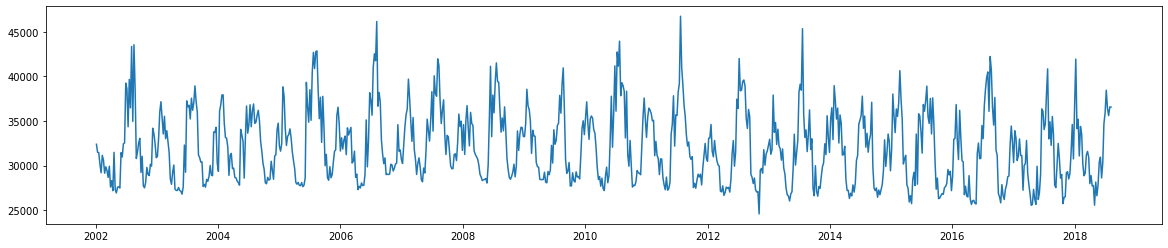

In [5]:
# Построим график целевой переменной
plt.figure(figsize =(20,4))
plt.plot(df_week['PJME_MW'])

Из графика видно, что на рассматриваемом интервале отсутствует тренда в распределении целевого признака, поэтому признак 'year', мы можем удалить. Хотя, если мы будем рассматривать больший промежуток времени, скажем несколько столетий или век, данный показатель нам может пригодиться, ведь со временем изобретаются новые технологии которые уменьшают потребление энергии, или строятся новые производства которые могут вызывать существенный рост потребления.

Также нам ни чем не поможет признаки 'dayofmonth' и 'dayofyear', поскольку в недельном ресемплинге не важно на какой день закончилась наша неделя или какой это день в году, поэтому этоти признак мы тоже удаляем.

Признаки 'dayofweek' и 'hour' будут принимать константные значения поэтому они нам тоже не помогут, удаляем.

Признаки 'month' и 'quarter' оставляем, ведь у нас есть сезонности, потребление энергии меняется в течении года, но для недель которые приходятся на разные месяца или кварталы мы округлим его до целого.

Признаки 'is_holiday', 'is_prev_holiday', 'is_next_holiday' в недельном ресемплинге может и не будут иметь какой-то серьезной значимост, но решил оставить ради эксперимента и обозначения, что на неделе есть праздники или предпраздничные дни, округлим полученные значения до 1 (в большую сторону).

In [6]:
# Функция округления в большую сторону
def my_round(num, n):
    x = num * 10**n
    d = x - x.astype('int')
    return np.where(d > 0, np.ceil(x), np.floor(x)) / 10**n

In [7]:
df_week.drop(['year', 'dayofmonth', 'dayofyear', 'dayofweek', 'hour'], axis=1, inplace=True)
df_week = df_week.round({'month': 0, 'quarter': 0})
df_week['is_holiday'] =  my_round(df_week['is_holiday'], 0)
df_week['is_prev_holiday'] =  my_round(df_week['is_prev_holiday'], 0)
df_week['is_next_holiday'] =  my_round(df_week['is_next_holiday'], 0)

In [8]:
df_week.head(10)

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,
2002-01-06,32392.160839,1.0,1.0,1.0,1.0,0.0,1.0
2002-01-13,31487.386905,1.0,1.0,2.0,0.0,0.0,0.0
2002-01-20,31452.880952,1.0,1.0,3.0,0.0,1.0,0.0
2002-01-27,30141.529762,1.0,1.0,4.0,1.0,0.0,1.0
2002-02-03,29196.488095,1.0,1.0,5.0,0.0,0.0,0.0
2002-02-10,31150.517857,2.0,1.0,6.0,0.0,0.0,0.0
2002-02-17,30616.565476,2.0,1.0,7.0,0.0,1.0,0.0
2002-02-24,29144.130952,2.0,1.0,8.0,1.0,0.0,1.0
2002-03-03,29869.011905,2.0,1.0,9.0,0.0,0.0,0.0


In [9]:
# X = df_week.iloc[0].values
# X

In [10]:
# X = df_week.iloc[0, : -1].values
# X

Стандартизируем наши признаки и попробуем выделить кластеры

In [11]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = df_week.values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

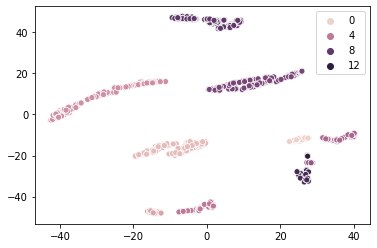

In [12]:
clast_0 = DBSCAN(eps=3, leaf_size=15)
X_clast =clast_0.fit_predict(X_t)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

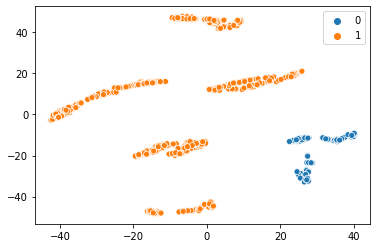

In [13]:
clast_1 = DBSCAN(eps=3, leaf_size=5)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast)
plt.show()

Мы видим два четко разделимых кластера, это можно использовать в качестве признака.

In [14]:
print('Число кластеров в календаре: ',len(np.unique(X_clast)))
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))

Число кластеров в календаре:  11
Число кластеров в календаре с масштабированием:  2


Оба варианта кластеризации, мне кажутся достаточно обаснованными, т.к. в 1 варианте, 10 кластеров, это практически отражение потребления энергии по месяцам, а во втором варианте, 2 кластера, это периоды с повышенным и пониженным потребление энергии, но это всего лишь мое предположение.

Было бы время попробовал бы оба варианта, но сейчас мне нравится больше 2.

In [15]:
df_week['day_week_month'] = X_scale_clast

Добавим еще признаков в модель

In [16]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [17]:
df_week['pca1']=Xpca[:,0]
df_week['pca2']=Xpca[:,1]

In [18]:
first_diff =np.array(df_week.iloc[1:,0].values - df_week.iloc[:-1,0].values).astype('float32') 
df_week['diff1'] = 0
df_week['diff1'] =  df_week['diff1'].astype('float') 
df_week['diff1'].values[1:] = first_diff

In [19]:
first_diff_d =(first_diff) / df_week.iloc[1:,0].values
df_week['diff1_d'] = 0
df_week['diff1_d'] =  df_week['diff1_d'].astype('float') 
df_week['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

In [20]:
first_diff_l =np.log(df_week.iloc[1:,0].values) 
df_week['diff1_l'] = 0
df_week['diff1_l'] =  df_week['diff1_l'].astype('float') 
df_week['diff1_l'].values[1:] = first_diff_l

In [21]:
df_week['d_w7']=df_week['PJME_MW'].rolling(window=7).mean()

In [22]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

df_week['exp_0_05'] = exponential_smoothing(df_week['PJME_MW'], 0.05)

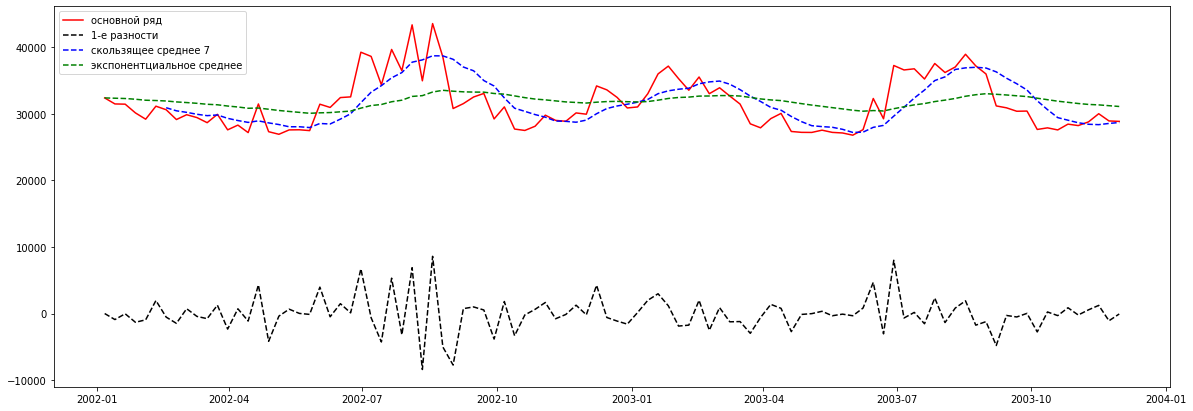

In [23]:
N100=100
plt.figure(figsize =(20,7))
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(df_week.index[:N100],df_week['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(df_week.index[:N100],df_week['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

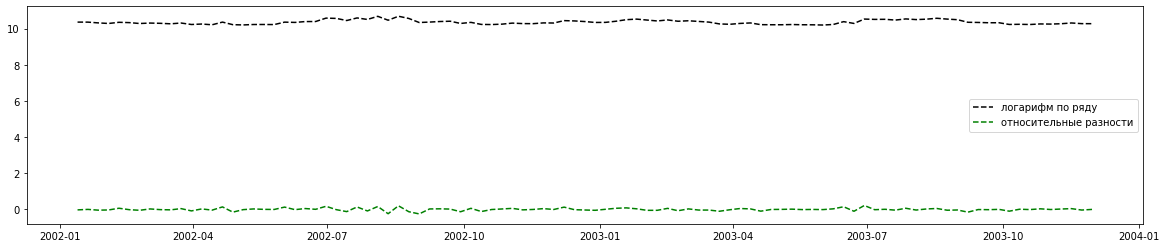

In [24]:
N100=100
plt.figure(figsize =(20,4))
plt.plot(df_week.index[1:N100],df_week['diff1_l'][1:N100],'--k',label ='логарифм по ряду')
plt.plot(df_week.index[1:N100],df_week['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

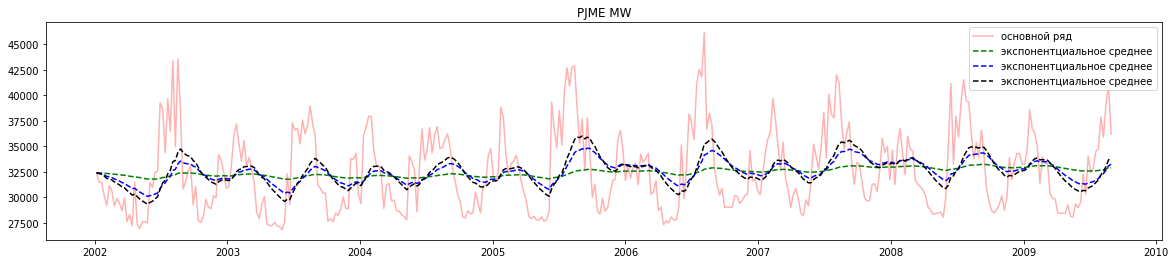

In [26]:
df_week['exp_0_01'] = exponential_smoothing(df_week['PJME_MW'], 0.01)
df_week['exp_0_03'] = exponential_smoothing(df_week['PJME_MW'], 0.03)
df_week['exp_0_04'] = exponential_smoothing(df_week['PJME_MW'], 0.04)
df_week['exp_0_06'] = exponential_smoothing(df_week['PJME_MW'], 0.06)
df_week['exp_0_07'] = exponential_smoothing(df_week['PJME_MW'], 0.07)
df_week['exp_0_08'] = exponential_smoothing(df_week['PJME_MW'], 0.08)

N100=400
plt.figure(figsize =(20,4))
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(df_week.index[:N100],df_week['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

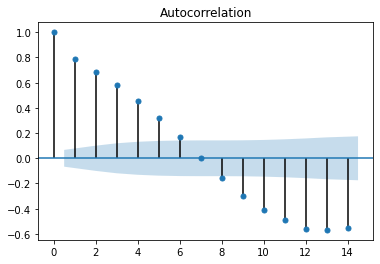

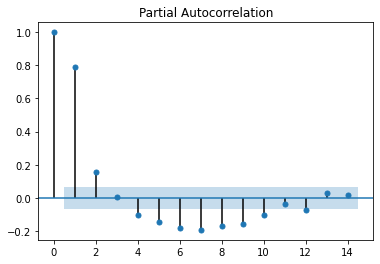

In [27]:
sm.graphics.tsa.plot_acf(df_week['PJME_MW'].values, lags=14)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(df_week['PJME_MW'].values, lags=14)
plt.show()

In [28]:
p = 1
for i in range(p):
    df_week['t'+str(p-i)]=0
    df_week['t'+str(p-i)].values[p:] = df_week['PJME_MW'].values[i:-(p)+i]

In [29]:
p = 1
for i in range(p):
    df_week['d'+str(p-i)]=0
    df_week['d'+str(p-i)].values[p:] = df_week['diff1'].values[i:-(p)+i]

In [30]:
# Наш окончательный набор признаков
df_week.fillna(0, inplace=True)
df_week.head(10)

,PJME_MW,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,day_week_month,pca1,pca2,...,d_w7,exp_0_05,exp_0_01,exp_0_03,exp_0_04,exp_0_06,exp_0_07,exp_0_08,t1,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.0,1.0,1.0,1.0,0.0,1.0,0,-1.775654,3.381100,...,0.000000,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,0,0
2002-01-13,31487.386905,1.0,1.0,2.0,0.0,0.0,0.0,1,-2.760307,0.089481,...,0.000000,32346.922142,32383.113100,32365.017621,32355.969882,32337.874403,32328.826664,32319.778924,32392,0
2002-01-20,31452.880952,1.0,1.0,3.0,0.0,1.0,0.0,1,-2.308112,0.748359,...,0.000000,32302.220083,32373.810778,32337.653521,32319.846325,32284.774796,32267.510464,32250.427087,31487,-904
2002-01-27,30141.529762,1.0,1.0,4.0,1.0,0.0,1.0,0,-1.666878,3.343187,...,0.000000,32194.185567,32351.487968,32271.769808,32232.713662,32156.180094,32118.691815,32081.715301,31452,-34
2002-02-03,29196.488095,1.0,1.0,5.0,0.0,0.0,0.0,1,-2.651531,0.051568,...,0.000000,32044.300693,32319.937969,32179.511357,32111.264639,31978.598574,31914.137554,31850.897124,30141,-1311
2002-02-10,31150.517857,2.0,1.0,6.0,0.0,0.0,0.0,1,-2.453679,-0.017086,...,0.000000,31999.611551,32308.243768,32148.641552,32072.834768,31928.913731,31860.684176,31794.866783,29196,-945
2002-02-17,30616.565476,2.0,1.0,7.0,0.0,1.0,0.0,1,-2.001484,0.641792,...,30919.647127,31930.459248,32291.326985,32102.679270,32014.583996,31850.172836,31773.595867,31700.602678,31150,1954
2002-02-24,29144.130952,2.0,1.0,8.0,1.0,0.0,1.0,0,-1.360250,3.236620,...,30455.642857,31791.142833,32259.855025,32013.922820,31899.765875,31687.810323,31589.533323,31496.084940,30616,-533
2002-03-03,29869.011905,2.0,1.0,9.0,0.0,0.0,0.0,1,-2.344903,-0.054999,...,30224.446429,31695.036287,32235.946594,31949.575493,31818.535716,31578.682418,31469.096823,31365.919097,29144,-1472


2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 4, тогда target = y(t+h)=y(t+1) 

In [51]:
scl_target=StandardScaler() 

h=4
target = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(861, 1)

In [52]:
scl_x=StandardScaler() 

X = df_week.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(861, 23)

Отберем признаки которые наилучшим образом подходят для построения модели

In [72]:
# # Линейная регрессия
# f_test, _ = f_regression(X, y.ravel())
# f_test /= np.max(f_test)
# for i in range(X.shape[1]):
#     print("F-test={:.2f},  I={}".format(f_test[i],i))

In [54]:
df_week.iloc[p:-h,:].columns[0], df_week.iloc[p:-h,:].columns[12], df_week.iloc[p:-h,:].columns[21]

('PJME_MW', 'diff1_l', 't1')

In [55]:
# Отбор признаков по регрессионному признаку
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(861, 5)

In [56]:
column_names = df_week.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_d', 'diff1_l', 't1', 'd1'], dtype='object')

In [57]:
# Отбор наиболее информативных признаков 
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(861, 3)

In [58]:
column_namesp = df_week.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 't1'], dtype='object')

In [59]:
# Отбор наиболее значимых признаков на основе модели
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(861, 5)

In [60]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 21 22]
Номера признаков лучших признаков по процентной форме:  [ 0 12 21]
Номера признаков для выбора по модели :  [ 0  3  8 12 20]


In [61]:
# Объединяем признаки
list_par = list(list_param_k.copy())
list_par.extend(list(list_param_p))
list_par.extend(list(list_param_m))
list_par = list(set(list_par))
print(list_par)

[0, 3, 8, 11, 12, 20, 21, 22]


In [62]:
# Оставляем для обучения отобранные признаки
X_new = X[:,list_par]
df_week.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'pca1', 'diff1_d', 'diff1_l', 'exp_0_08', 't1',
       'd1'],
      dtype='object')

In [63]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [71]:
# Разбиваем данные
train, test = split_data(df_week, '01-06-2016')

# plt.figure( figsize=( 15, 7 ))
# plt.xlabel('Время')
# plt.ylabel('Потребление энергии, МВт')
# plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
# plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
# plt.title( 'Тестовые и тренировочные данные' )
# plt.legend()
# plt.show()

In [65]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [66]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [67]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
# Подбираем параметры для модели
param_dist = {"max_depth": [3, 2,1,4,5,6,7,8,9,10], 
              "n_estimators":[100,200,300,400,500,600,700,800,900]}
n_iter_search = 20
model_gr =GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search,
                                   cv=5, iid=False)
random_search.fit(X_train, y_train)
report(random_search.cv_results_)

/home/aleksandr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Model with rank: 1
Mean validation score: 0.630 (std: 0.057)
Parameters: {'n_estimators': 700, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.606 (std: 0.062)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.603 (std: 0.056)
Parameters: {'n_estimators': 100, 'max_depth': 2}



In [69]:
# Обучаем модель
model_g_best = GradientBoostingRegressor(max_depth=1,  n_estimators=700)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.506168281757596 %


In [70]:
# Сохраняем модели
filename = 'final_model_h4.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y_h4.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x_h4.sav'
pickle.dump(scl_x, open(filename, 'wb'))

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [73]:
scl_target=StandardScaler() 

h=1
target = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(864, 1)

In [74]:
scl_x=StandardScaler() 

X = df_week.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(864, 23)

In [75]:
df_week.iloc[p:-h,:].columns[0], df_week.iloc[p:-h,:].columns[12], df_week.iloc[p:-h,:].columns[21]

('PJME_MW', 'diff1_l', 't1')

In [76]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(864, 5)

In [77]:
column_names = df_week.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_08', 't1'], dtype='object')

In [78]:
# Отбор наиболее информативных признаков 
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(864, 3)

In [79]:
column_namesp = df_week.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 't1'], dtype='object')

In [80]:
# Отбор наиболее значимых признаков на основе модели
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(864, 2)

In [81]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 12 13 20 21]
Номера признаков лучших признаков по процентной форме:  [ 0 12 21]
Номера признаков для выбора по модели :  [ 0 12]


In [82]:
# Объединяем признаки
list_par = list(list_param_k.copy())
list_par.extend(list(list_param_p))
list_par.extend(list(list_param_m))
list_par = list(set(list_par))
print(list_par)

[0, 12, 13, 20, 21]


In [83]:
# Оставляем для обучения отобранные признаки
X_new = X[:,list_par]
df_week.columns[list_par]

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_08', 't1'], dtype='object')

In [84]:
# Разбиваем данные
train, test = split_data(df_week, '01-06-2016')

In [85]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [86]:
# Подбираем параметры для модели
param_dist = {"max_depth": [3, 2,1,4,5,6,7,8,9,10], 
              "n_estimators":[100,200,300,400,500,600,700,800,900]}
n_iter_search = 20
model_gr =GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search,
                                   cv=5, iid=False)
random_search.fit(X_train, y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.644 (std: 0.053)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.633 (std: 0.056)
Parameters: {'n_estimators': 700, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.631 (std: 0.056)
Parameters: {'n_estimators': 800, 'max_depth': 1}



/home/aleksandr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [88]:
# Обучаем модель
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.1446999314936175 %


Естественно, что ошибка модели для h=1 меньше чем для h=4

In [ ]:
Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_08', 't1'], dtype='object')

In [ ]:
['PJME_MW', 'dayofweek', 'pca2', 'diff1_l', 'd_w7', 'exp_0_07',
       'exp_0_08'],

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [107]:
# Функция для предсказания n следующих точек
def predict_n_value(model, test_x, test_y, n):
    X_test_100 = test_x.copy()
    y_test_100 = test_y.copy()
    for i in range(n):
        y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,5)))
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = y_test_100[i]
        X_test_100[i+1,3] = X_test_100[i+1,0]*(1-0.08)+ 0.08 * X_test_100[i,3] 
        if i>p:
            X_test_100[i+1,2] = np.mean(X_test_100[i+1-p:i+1,0])
        if i%10 == 0:
            start = i
            end = i+10
            er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[start: end]),
                                              y_pred = scl_target.inverse_transform(y_test_100[start: end]))
            print(f'ошибка градиентного бустинга MAPE c {start} по {end} предсказание: {er_g}')
    
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:n]),
                                          y_pred = scl_target.inverse_transform( y_test_100[:n]))
    print('\nошибка градиентного бустинга MAPE по всему диапазону предсказаний:  ', er_g,'%')
    return y_test_100

In [99]:
# Предсказываем следующие 4 значения
pred_interval = 4
y_test_pred = predict_n_value(model_g_best, X_test, y_test_pred_g, pred_interval)

ошибка градиентного бустинга MAPE :   7.9029529250952235 %


По сравнению с предсказанием 1 значения ошибка возросла

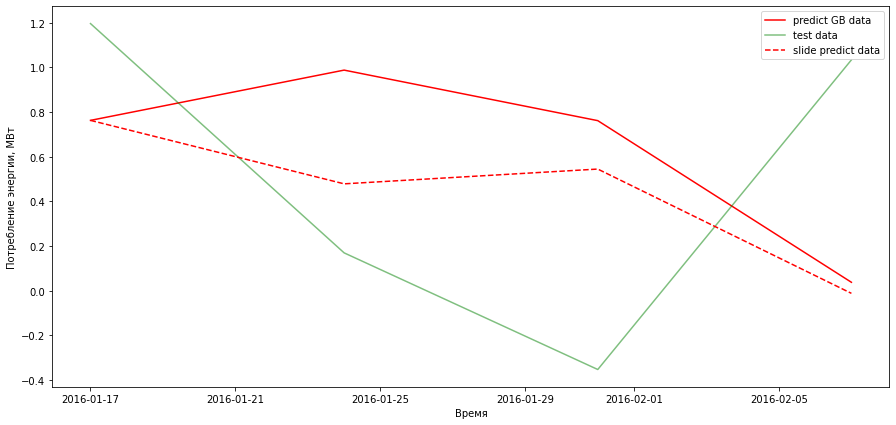

In [92]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:pred_interval+1],y_test_pred_g[:pred_interval], 'r',label='predict GB data' )
plt.plot(test.index[1:pred_interval+1],y_test[:pred_interval], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:pred_interval+1],y_test_pred[:pred_interval], '--r',label='slide predict data')

plt.legend()
plt.show()   

На графике видно, что рост ошибки вызван резким снижением потребления энергии.

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

In [108]:
# Предсказываем на 100 точек вперед
pred_interval = 100
y_test_pred = predict_n_value(model_g_best, X_test, y_test_pred_g, pred_interval)

ошибка градиентного бустинга MAPE c 0 по 10 предсказание: 8.359710516989747
ошибка градиентного бустинга MAPE c 10 по 20 предсказание: 9.458890093493375
ошибка градиентного бустинга MAPE c 20 по 30 предсказание: 6.045293186697083
ошибка градиентного бустинга MAPE c 30 по 40 предсказание: 7.5009063142110675
ошибка градиентного бустинга MAPE c 40 по 50 предсказание: 4.930308319608093
ошибка градиентного бустинга MAPE c 50 по 60 предсказание: 5.86477133025611
ошибка градиентного бустинга MAPE c 60 по 70 предсказание: 9.104644664482157
ошибка градиентного бустинга MAPE c 70 по 80 предсказание: 8.892357302085852
ошибка градиентного бустинга MAPE c 80 по 90 предсказание: 8.71489416491198
ошибка градиентного бустинга MAPE c 90 по 100 предсказание: 6.202546275728112

ошибка градиентного бустинга MAPE по всему диапазону предсказаний:   8.492696840527238 %


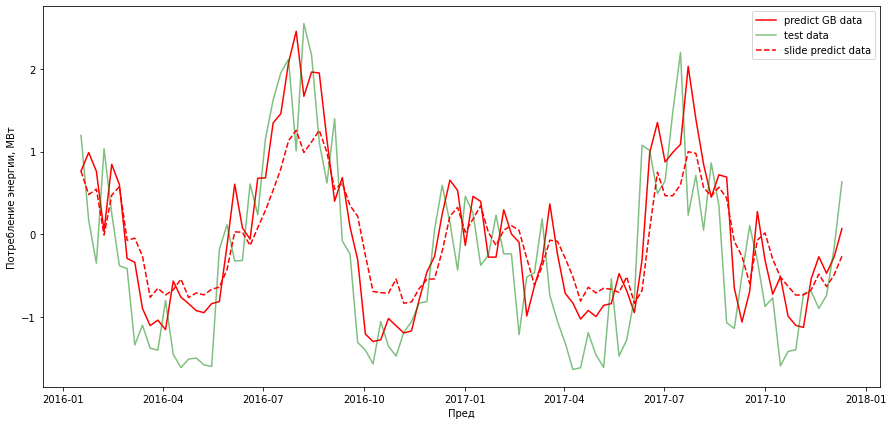

In [109]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Пред')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:pred_interval+1],y_test_pred_g[:pred_interval], 'r',label='predict GB data' )
plt.plot(test.index[1:pred_interval+1],y_test[:pred_interval], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:pred_interval+1],y_test_pred[:pred_interval], '--r',label='slide predict data')

plt.legend()
plt.show()   

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Мы видим, что на разных интервалах ошибка меняется, иногда в лучшую сторону, а иногда в худшую. Это связано с резким изменением показателей потребления энергии (модель не успевает уловить эти изменения), чем быстерее и больше он меняется, тем больше становится ошибка, а когда показатель какоето время принимает значения в небольшом диапазоне, то ошибка уменьшается.